# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


In [2]:
from utils import wdn_test

import importlib
importlib.reload(wdn_test)

<module 'utils.wdn_test' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/wdn_test.py'>

### Imports

In [5]:
!pip install wntr
%matplotlib inline
import wntr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.2 MB 5.2 MB/s 


## Main

### Using the network

['10', '11', '12', '13', '21', '22', '23', '31', '32', '9', '2']
[('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


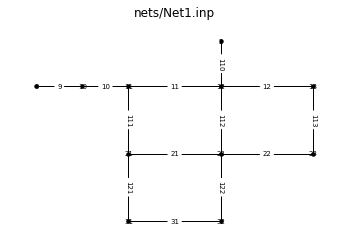

In [6]:
# Import the network and display it

inp_file = "nets/Net1.inp"
wn = wntr.network.WaterNetworkModel(inp_file)
print(wn.get_graph().nodes())
print(wn.get_graph().edges())
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True, link_labels=True)

In [9]:
# Start simulation

wn.reset_initial_values()
wn.options.time.duration = 10*24*3600  # Simulation of 240 hours = 10 days
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()  # Pressure, ... for every hour!

print(results.link.keys())
print(results.node.keys())

results.node['pressure'].iloc[:10]

odict_keys(['flowrate', 'velocity', 'status', 'setting'])
odict_keys(['head', 'demand', 'pressure', 'leak_demand'])


,10,11,12,13,21,22,23,31,32,2,9
0,89.717130,83.890240,82.317283,83.476384,82.767420,83.539083,84.931053,81.500957,77.934100,36.576000,0.0
3600,90.454975,84.729419,83.251557,84.406591,83.667533,84.464284,85.857823,82.406828,78.848088,37.511171,0.0
7200,90.917697,85.255764,84.155155,85.054056,83.953429,84.992243,86.371004,82.307474,78.707016,38.424866,0.0
10800,91.417113,85.823913,84.786312,85.681660,84.562265,85.614871,86.994754,82.919401,79.322925,39.056463,0.0
14400,91.644594,86.082723,85.396615,85.978687,84.503056,85.736957,87.100245,82.392488,78.709200,39.673319,0.0
18000,91.915437,86.390886,85.738056,86.317854,84.833037,86.072733,87.436644,82.723754,79.042040,40.014902,0.0
21600,91.920471,86.396613,86.068577,86.283435,84.448129,85.817498,87.162554,81.793351,77.989881,40.348425,0.0
25200,91.972055,86.455308,86.133419,86.347792,84.510932,85.881105,87.226280,81.856331,78.053073,40.413273,0.0
28800,92.281491,86.807411,86.199548,86.776259,85.279059,86.526528,87.891282,83.171498,79.491894,40.476583,0.0
32400,92.537248,87.098454,86.522001,87.096546,85.590717,86.843575,88.208918,83.484349,79.806207,40.799165,0.0


<Figure size 432x288 with 0 Axes>

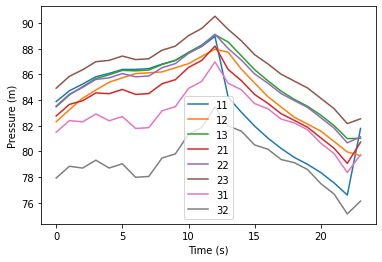

In [15]:
plt.figure()
pressures = results.node["pressure"].iloc[:24*1].loc[:,['11','12','13','21','22','23','31','32']]
pressures['hour'] = list(range(pressures.shape[0]))
pressures = pressures.set_index('hour')
ax = pressures.plot()
text = ax.set_xlabel("Time (s)")
text = ax.set_ylabel("Pressure (m)")
plt.show()

In [26]:
pressures = results.node["pressure"]
pressures['hour'] = list(range(pressures.shape[0]))
pressures['day'] = pressures['hour'] // 24
pressures['hour of the day'] = pressures['hour'] % 24
pressures = pressures.set_index('hour')
pressures[45:50]

,10,11,12,13,21,22,23,31,32,2,9,hour of the day,day
hour,,,,,,,,,,,,,
45,79.266408,79.266408,82.496056,83.735233,81.971743,83.541559,85.050875,81.555645,78.402902,36.792202,0.0,21,1
46,78.321652,78.321652,81.679120,82.717877,80.785864,82.387920,83.886903,80.076971,76.850522,35.986627,0.0,22,1
47,77.247553,77.247553,80.605021,81.643777,79.711765,81.313820,82.812803,79.002871,75.776423,34.912528,0.0,23,1
48,76.001011,76.001011,79.516846,80.307284,78.166476,79.808475,81.294657,77.094814,73.777047,33.838428,0.0,0,2
49,87.920253,81.847165,80.042822,81.211569,80.576100,81.285967,82.674148,79.295419,75.708335,34.299318,0.0,1,2


In [38]:
pressures_at_hour_12 = pressures[pressures['hour of the day'] == 1].set_index('day').loc[:,['11','12','13','21','22','23','31','32']]
pressures_at_hour_12

,11,12,13,21,22,23,31,32
day,,,,,,,,
0,84.729419,83.251557,84.406591,83.667533,84.464284,85.857823,82.406828,78.848088
1,83.500387,81.883263,83.044233,82.349269,83.109217,84.500460,81.080115,77.509448
2,81.847165,80.042822,81.211569,80.576100,81.285967,82.674148,79.295419,75.708335
3,76.105543,79.621378,80.411817,78.271009,79.913008,81.399189,77.199347,73.881580
4,76.888380,80.404215,81.194653,79.053845,80.695844,82.182026,77.982184,74.664416
5,77.208078,80.723913,81.514351,79.373543,81.015542,82.501724,78.301882,74.984114
6,77.291580,80.807415,81.597853,79.457045,81.099044,82.585226,78.385384,75.067616
7,77.309284,80.825119,81.615558,79.474749,81.116749,82.602930,78.403088,75.085320
8,77.312438,80.828273,81.618711,79.477903,81.119903,82.606084,78.406242,75.088474


<Figure size 432x288 with 0 Axes>

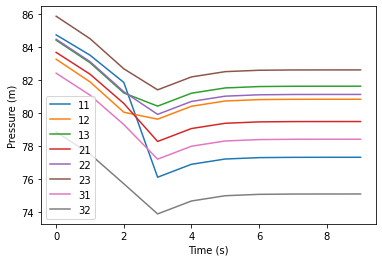

In [39]:
plt.figure()
ax = pressures_at_hour_12.plot()
text = ax.set_xlabel("Time (s)")
text = ax.set_ylabel("Pressure (m)")
plt.show()